<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb) | [Contents](Index.ipynb) | [Feature Engineering](05.04-Feature-Engineering.ipynb) >

# 超参数和模型验证

在上一节中，我们看到了应用监督机器学习模型的基本方法：
1. 选择模型分类
2. 选择模型超参数
3. 用模拟数据拟合模型
4. 用模型来预测新数据的标签


前两部分—模型的选择和超参数的选择—可能是有效使用这些机器学习工具和技术的最重要的部分。
为了做出正确的选择，我们需要一种方法来验证我们的模型和超参数是否可以很好的拟合数据。
虽然这听起来很简单，但要想顺利完成也必须避过一些坑

## 什么是模型验证

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

模型验证其实非常简单：在选择模型及其超参数之后，我们可以通过将模型应用到一些训练数据并将预测与已知值进行比较来估计它的有效性。

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

下面的部分首先展示了一种简单的模型验证方法，以及为什么它失败，在探索使用留出集（holdout sets）和交叉验证（cross-validation）以实现更可靠的模型验证。

### Model validation the wrong way 错误的模型验证方法

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section.
We will start by loading the data:

让我们用前面用过的 Iris 数据来演示一个简单的模型验证方法，我们将从加载数据开始：

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

接下来，我们选择一个模型和超参数。在这里我们将使用“n_neighbors=1”的 k-neighbors 分类器。
这是一个非常简单和直观的模型， “未知点的标签和它最接近的训练点的标签是一样的：”

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

然后我们训练模型，用它来预测我们已经知道的数据的标签：

In [3]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

最后，计算模型的准确率：

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

我们看到准确率是1.0，这表明100%的点被我们的模型正确地标记了！这样测量的准确率可靠吗？我们真的有了一个任何时候都能百分百正确的模型吗？

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

事实上，这种方法包含一个基本的缺陷：它在相同的数据上对模型进行了训练和评估。此外，k-neighbors 是一种与距离相关的评估器，它简单地存储训练数据，并通过将新数据与这些存储点进行比较来预测标签：除了在人为的情况下，它每次都会得到百分之百的准确性！

### Model validation the right way: Holdout sets 模型验证正确方法：留出集

So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

那么，我们能做些什么呢？可以通过所谓的“holdout set”来找到更好的模型性能：也就是说，我们从模型的培训中保留了一些数据的子集，然后使用这部分预留的数据集合来检查模型的性能。这种分离可以通过Scikit-Learn中的train_test_split实用工具来完成：

In [6]:
from sklearn.cross_validation import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

我们在这里看到了一个更合理的结果：在这个 hold-out 的集合中，邻近的分类器大约有90%的准确率。这个 hold-out 的集合类似于未知的数据，因为这个模型以前没有“看到”它。

### Model validation via cross-validation  交叉验证

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

在使用 holdout 模型验证有一个缺点，就是一部分数据没有参与到模型训练当中。在上面的例子中，一半的数据集对模型的训练没有贡献！
这当然不是最优的，并且会导致问题——特别是训练数据集是很小的时候。

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

解决这个问题的方法是使用交叉验证;也就是说，要做一系列的调整，其中的每个子集都被用作训练集和验证集，从图形上看，它可能是这样的：

![](figures/05.03-2-fold-CV.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#2-Fold-Cross-Validation)

Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

在这里，我们做两个验证试验，交替使用每一半的数据作为 留出集。使用以前的分割数据，我们可以像这样实现它：

In [7]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

结果是两个准确率，我们可以结合（比如说，取均值）来更好地衡量整个模型的性能。这种交叉验证的特殊形式是`双重交叉验证`——也就是说，我们将数据分割成两组，并依次作为验证集使用。

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

我们可以扩展这个想法，在数据中实现多轮的交叉验证——例如，这里有一个五轮交叉验证的图形描述：

![](figures/05.03-5-fold-CV.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#5-Fold-Cross-Validation)

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

在这里，我们将数据分成5组，然后依次使用它们来评估模型是否适合其他4/5的数据。
这将是一件相当乏味的事情，所以我们可以使用Scikit-Learn的“cross_val_score”便利程序来简洁地完成：

In [8]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

在数据的不同子集上重复验证，使我们对算法的性能有了更好的了解。

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.

Scikit-Learn实现了许多有用的交叉验证方案，这些方案在特定情况下是有用的;这些是通过 ``cross_validation`` 模块中的迭代器实现的。

For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

例如，我们可能希望进入一个极端的情况，在这个例子中，我们的折叠数等于数据点的数量：也就是说，我们在所有的点上进行训练，但是在每次都只用其中一个点验证。
这种类型的交叉验证被称为 LOO （ leave-one-out 只留一个）交叉验证，可以使用如下：

In [9]:
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

In [9]:
scores.mean()

0.95999999999999996

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).


其他交叉验证方案也可以类似地使用方法。想了解更多 Scikit-Learn 的内容，请使用IPython来探索 ``sklearn.cross_validation`` 交叉验证子模块，或者看一下Scikit-Learn 交叉验证的在线文档。

## Selecting the Best Model 选择最好的模型

Now that we've seen the basics of validation and cross-validation, we will go into a litte more depth regarding model selection and selection of hyperparameters.

 我们已经了解了验证和交叉验证的基础知识，我们将更深入地讨论模型选择和超参数的选择。

These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

这些问题是机器学习实践中最重要的一些方面，我发现这些信息在入门的机器学习教程中经常被掩盖。

Of core importance is the following question: *if our estimator is underperforming, how should we move forward?*
There are several possible answers:

最重要的是以下问题：如果我们的评估器表现不佳，我们应该如何前进？有几个可能的答案：

- Use a more complicated/more flexible model  使用更复杂/更灵活的模型
- Use a less complicated/less flexible model  使用一个不太复杂/不太灵活的模型
- Gather more training samples           收集更多的训练样本
- Gather more data to add features to each sample  集更多的数据，为每个样本添加更多的特征

The answer to this question is often counter-intuitive.
In particular, sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results!
The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

这个问题的答案往往是反直觉的。特别是，有时使用更复杂的模型会带来更糟糕的结果，增加更多的训练样本可能不会改善你的结果！改善模型性能能力的高低，是机器学习实践者是否成功的标志。

### The Bias-variance trade-off  偏差和方差权衡

Fundamentally, the question of "the best model" is about finding a sweet spot in the tradeoff between *bias* and *variance*.
Consider the following figure, which presents two regression fits to the same dataset:

从根本上说，“最佳模型”的问题在于如何在偏差和方差之间找到一个平衡点。如图所示，它给出了拟合同一个数据集的两个不同的回归模型：

![](figures/05.03-bias-variance.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff)

It is clear that neither of these models is a particularly good fit to the data, but they fail in different ways.

很明显，这两种模型拟合的都不是特别好，但它们的问题却不一样。

The model on the left attempts to find a straight-line fit through the data.
Because the data are intrinsically more complicated than a straight line, the straight-line model will never be able to describe this dataset well.

左边的模型试图通过数据找到一条直线。因为数据本质上比直线更复杂，所以直线模型永远不能很好地描述这个数据集。

Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

这样的模型被认为是不符合数据的：也就是说，它没有足够的模型灵活性来适当地解释数据中的所有特性;另一种说法是模型有很高的``偏差``。

The model on the right attempts to fit a high-order polynomial through the data.
Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data.
Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

右边的模型试图通过数据来匹配高阶多项式。这里模型适合有足够的灵活性,几乎完全适应了所有的数据特征,但即使它非常准确地描述了训练数据,其精确的形式似乎更反映特定噪声数据而不是内在属性的属性的过程生成的数据。这样的模型被认为过于拟合数据：也就是说，它具有如此多的模型灵活性，以至于模型适应的所有数据特征的同时也适应了随机误差; 另一种说法就是模型具有``高方差``

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data.
In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

从另一个角度来看，考虑一下如果我们使用这两个模型来预测一些新数据的y值，会发生什么。在下面的图中，浅红点表示训练集中遗漏的数据：

![](figures/05.03-bias-variance-2.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Bias-Variance-Tradeoff-Metrics)

The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values. $R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

这里的得分是$R^2$ score，也就是确定系数，它衡量一个模型相对于目标值的简单平均值的表现。$R^2=1$表示一个完美的匹配， $R^2=0$表明模型并不比简单地取数据的平均值好，而负的值意味着更糟糕的模型。从与这两种模型相关的分数中，我们可以得出一个更普遍的观察结果：

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
对于高偏差模型，在验证集中的模型的性能与训练集的性能相似。
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.
对于高方差模型，在验证集中的模型的性能要比训练集的性能差得多。

If we imagine that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the following figure:

假设我们有能力调整模型的复杂度，我们会期望训练分数和验证分数表现得如下图所示：

![](figures/05.03-validation-curve.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Validation-Curve)

The diagram shown here is often called a *validation curve*, and we see the following essential features:
这里所示的图表通常被称为``验证曲线``，我们可以看到以下基本特征：

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.  训练分数在任何地方都比验证分数高。这通常是这样的：模型将更适合于它所接触过的数据。
- For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data. 对于非常低的模型复杂度（高偏差模型），训练集数据是不合适的，这意味着模型对于训练数据和任何以前未接触过的数据都不能很好的预测。
- For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.  对于非常高的模型复杂度（高方差模型），训练数据过于拟合，这意味着模型很好地预测了训练数据，但是对于之前没遇到过的数据来说预测效果是很差的。

- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.  对于某些中间值，验证曲线是最大的。这种复杂性表明了偏差和方差之间的适当权衡。

The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning. 对模型复杂性进行调优的方法因模型而异;当我们在后面的小节中深入讨论单个模型时，我们将看到每个模型如何进行这样的调优。

### Validation curves in Scikit-Learn  Scikit-Learn 的 验证曲线

Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:


让我们看一个使用交叉验证来计算类模型的验证曲线的例子。这里我们将使用一个多项式回归模型：这是一个广义线性模型，其中多项式的程度是一个可调参数。例如，多项式次数为 1，其实就是将数据的拟合成一条直线;模型参数  $a$ 和 $b$：

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

多项式次数为3，就是将数据拟合成一条3次曲线; 模型参数 $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.
We will use a *pipeline* to string these operations together (we will discuss polynomial features and pipelines more fully in [Feature Engineering](05.04-Feature-Engineering.ipynb)):


我们可以任意次数的多项式。在Scikit-Learn中，我们可以用一个带有多项式预处理器简单的线性回归实现。我们将使用一条管道将这些操作串在一起（我们将在特性工程中更全面地讨论多项式特性和管道）：

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# degree 多项式 次数
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

In [6]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

We can now visualize our data, along with polynomial fits of several degrees:

我们现在可以看到我们的数据，以及几个不同的多项式。

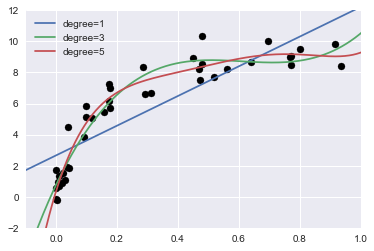

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

The knob controlling model complexity in this case is the degree of the polynomial, which can be any non-negative integer.
A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (under-fitting) and variance (over-fitting)?

在这种情况下，控制模型复杂度的是多项式的次数，它可以是任何非负整数。一个有用的问题是：多项式次数究竟是多少才能在偏差（不适当）和方差（过度拟合）之间提供权衡？

We can make progress in this by visualizing the validation curve for this particular data and model; this can be done straightforwardly using the ``validation_curve`` convenience routine provided by Scikit-Learn.
Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range:

我们可以通过可视化这个特定数据和模型的验证曲线来取得进展;这可以直接使用由Scikit-Learn提供的``validation_curve``便利程序来完成。给定一个模型、数据、参数名和一个可探索的范围，这个函数将自动计算训练分数和验证分数的所在范围：

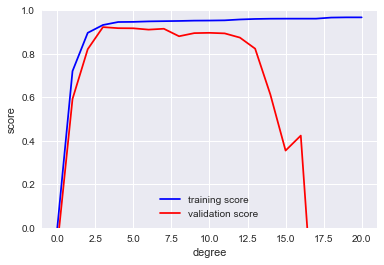

In [16]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.

这恰恰显示了我们所期望的定性行为：训练分数比验证分数高;训练分数随着模型复杂度的增加而单调地提高;当模型变得过于合适时，验证分数会达到最大值。

From the validation curve, we can read-off that the optimal trade-off between bias and variance is found for a third-order polynomial; we can compute and display this fit over the original data as follows:

从验证曲线中，我们可以看出，在三阶多项式中，存在偏差和方差之间的最佳权衡;我们可以根据原始数据来计算和显示这个匹配：

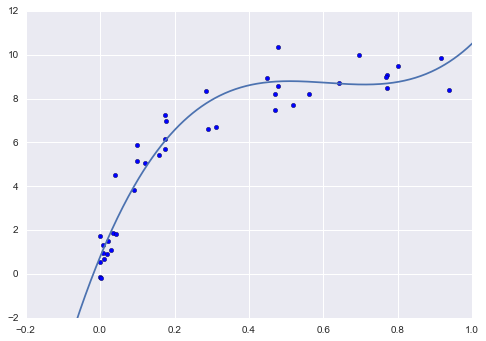

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

请注意，找到这个最优模型实际上并不要求我们计算训练分数，但是检查训练分数和验证分数之间的关系可以让我们对模型的性能有很好的了解。

## Learning Curves

One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:


模型复杂性的一个重要方面是，最优模型通常取决于您的训练数据集的大小。例如，让我们生成一个新的数据集，再增加5倍的点：

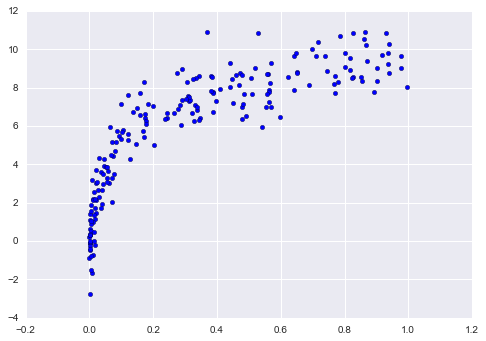

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

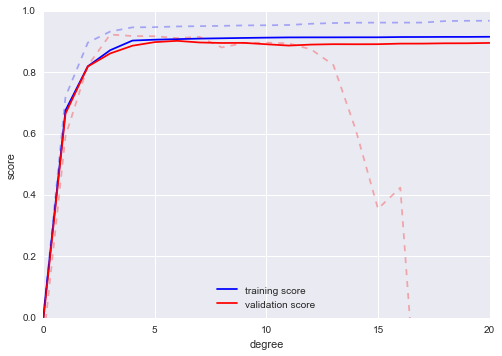

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

实线显示了新的结果，而较弱的虚线显示了先前较小数据集的结果。从验证曲线中可以清楚地看出，较大的数据集可以支持一个更加复杂的模型：这里的顶点可能在6次多项式，但即使是一个20次多项式的模型也没有严重地过度拟合数据——验证和训练分数仍然非常接近。

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
It is often useful to to explore the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
A plot of the training/validation score with respect to the size of the training set is known as a *learning curve.*

因此，我们看到验证曲线的行为不是一个而是两个重要的输入：模型的复杂性和训练点的数量。将模型看作为与训练数据的规模相关的函数，以此来观察模型的行为。反应训练集规模的训练分数/验证分数被称为``学习曲线``。

The general behavior we would expect from a learning curve is this:

我们从学习曲线中得到的一般行为是这样的：

- A model of a given complexity will *overfit* a small dataset: this means the training score will be relatively high, while the validation score will be relatively low. 一个给定的复杂性的模型相对于一个小的数据集容易过拟合：这意味着训练分数将相对较高，而验证分数将相对较低。
- A model of a given complexity will *underfit* a large dataset: this means that the training score will decrease, but the validation score will increase.  一个给定复杂度的模型相对于一个大数据集容易欠拟合：这意味着训练分数将会降低，但是验证分数将会增加。
- A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.  一个模型不会在验证集上比训练集给出一个更好的分数：这意味着曲线应该保持在更近的距离，但永远不会相交。

With these features in mind, we would expect a learning curve to look qualitatively like that shown in the following figure:

考虑到这些特性，我们期望学习曲线从质量上看如下图所示：

![](figures/05.03-learning-curve.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Learning-Curve)

The notable feature of the learning curve is the convergence to a particular score as the number of training samples grows.
In particular, once you have enough points that a particular model has converged, *adding more training data will not help you!*
The only way to increase model performance in this case is to use another (often more complex) model.

学习曲线的显著特征是随着训练样本数量的增加，它与一个特定的分数趋于一致。特别地，一旦你有了足够多的点，一个特定的模型已经聚合，添加更多的训练数据将不会对你有帮助！在这种情况下，提高模型性能的惟一方法是使用另一个（通常更复杂的）模型。

### Learning curves in Scikit-Learn

Scikit-Learn offers a convenient utility for computing such learning curves from your models; here we will compute a learning curve for our original dataset with a second-order polynomial model and a ninth-order polynomial:

Scikit-Learn提供了一种方便的实用工具，可以从你的模型中计算出这样的学习曲线;在这里，我们将用二阶多项式模型和九阶多项式来计算原始数据集的学习曲线：

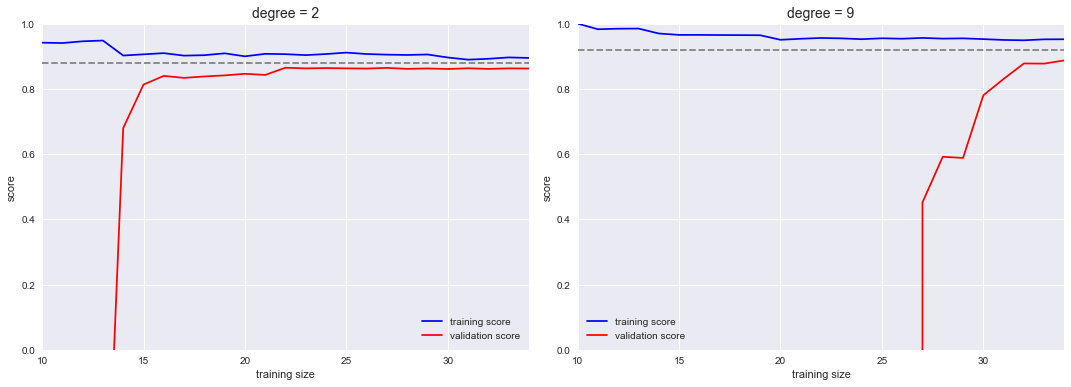

In [24]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, because it gives us a visual depiction of how our model responds to increasing training data.
In particular, when your learning curve has already converged (i.e., when the training and validation curves are already close to each other) *adding more training data will not significantly improve the fit!*
This situation is seen in the left panel, with the learning curve for the degree-2 model.

这是一个有价值的诊断，因为它给我们提供了一个可视化的描述，说明我们的模型是如何对不断增加的训练数据做出反应的。特别是当你的学习曲线已经收敛的时候（例如当训练和验证曲线已经接近彼此的时候）增加更多的训练数据将不会显著地提高适应性！这种情况在左边的面板中可以看到2次项式模型的学习曲线。

The only way to increase the converged score is to use a different (usually more complicated) model.
We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores).
If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

提高收敛分数的唯一方法是使用一个不同的（通常更复杂的）模型。我们在右边的面板中看到了这一点：采用一个更复杂度的模型之后，我们增加了收敛的分数（由虚线表示），但是代价是更高的模型方差（由训练和验证分数之间的差异来表示）。如果我们要添加更多的数据点，更复杂的模型的学习曲线最终会收敛。

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

您选择的模型和数据集绘制一条学习曲线，可以帮助您找到改进的正确方向，不断改进学习效果。

## Validation in Practice: Grid Search 实践验证：网格搜索

The preceding discussion is meant to give you some intuition into the trade-off between bias and variance, and its dependence on model complexity and training set size.
In practice, models generally have more than one knob to turn, and thus plots of validation and learning curves change from lines to multi-dimensional surfaces.
In these cases, such visualizations are difficult and we would rather simply find the particular model that maximizes the validation score.

前面的讨论是为了让您对偏差和方差之间的权衡有一些直观认识，以及它对模型复杂性和训练集大小的依赖。在实践中，模型通常有不止一个得分转折点，因此验证和学习曲线会从二维多维到多维的曲面。在这些情况下，这样的可视化是很困难的，我们宁愿简单地找到最大化验证分数的特定模型。

Scikit-Learn provides automated tools to do this in the grid search module.
Here is an example of using grid search to find the optimal polynomial model.
We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem.
This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

Scikit-Learn提供了在网格搜索模块中实现这一功能的自动化工具。这里有一个使用网格搜索来找到最优多项式模型的例子。我们将在一个三维的模型特征网格中寻找最优值，也就是多项式的次数的搜索范围，回归模型是否拟合截距，以及回归模型是否需要进行标准化处理。这可以使用Scikit-Learn的GridSearchCV元估计器来设置：

In [26]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

注意，就像普通的估计量一样，这还没有应用到任何数据上。调用fit（）方法将在每个网格点上拟合模型，并同时记录每个点的分数：

In [27]:
grid.fit(X, y);

Now that this is fit, we can ask for the best parameters as follows:

In [28]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

Finally, if we wish, we can use the best model and show the fit to our data using code from before:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:3356: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


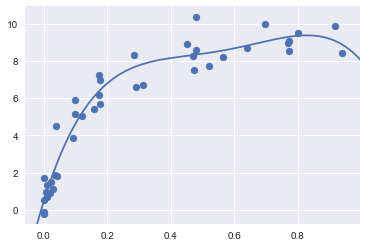

In [31]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test, hold=True);
plt.axis(lim);

The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.
For information, see the examples in [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) and [Feature Engineering: Working with Images](05.14-Image-Features.ipynb), or refer to Scikit-Learn's [grid search documentation](http://Scikit-Learn.org/stable/modules/grid_search.html).

## Summary

In this section, we have begun to explore the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias–variance trade-off and how it comes into play when fitting models to data.
In particular, we found that the use of a validation set or cross-validation approach is *vital* when tuning parameters in order to avoid over-fitting for more complex/flexible models.

In later sections, we will discuss the details of particularly useful models, and throughout will talk about what tuning is available for these models and how these free parameters affect model complexity.
Keep the lessons of this section in mind as you read on and learn about these machine learning approaches!

<!--NAVIGATION-->
< [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb) | [Contents](Index.ipynb) | [Feature Engineering](05.04-Feature-Engineering.ipynb) >